In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import collections

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pymc3 as pm

import scipy.stats as stats

from matplotlib.patches import Ellipse
import numpy.random as rnd

In [9]:
a = 3.5        # average morning wait time
b = -1         # average difference afternoon wait time

sigma_a = 1    # std dev in intercepts
sigma_b = 0.5  # std dev in slopes

rho = -0.7     # correlation between intercepts and slopes

# Multivariate normal
Mu = np.array([a, b])

# variance-covariance matrix
Sigma = np.array([
        [sigma_a**2, sigma_a * sigma_b * rho], 
        [sigma_a * sigma_b * rho, sigma_b**2]
    ])

N_cafes = 20
seed = 5

vary_effects = stats.multivariate_normal.rvs(mean=Mu, cov=Sigma, size=N_cafes ,random_state=5)

a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

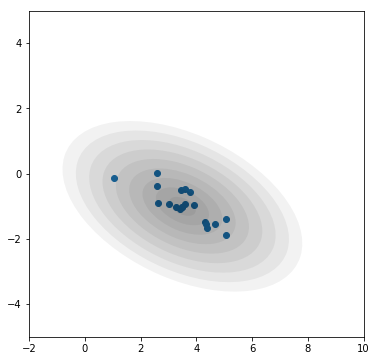

In [34]:
ells = [Ellipse(xy=(a, b), width=sigma_a * i, height=sigma_b * i, angle=340)
        for i in range(10)]

fig, ax = plt.subplots(1,1, figsize=(6, 6))

for e in ells:
    e.set_alpha(0.05)
    e.set_facecolor('k')
    ax.add_artist(e)

ax.scatter(a_cafe, b_cafe)

ax.set_xlim(-2, 10)
ax.set_ylim(-5, 5)

plt.show()

In [123]:
N_visits = 10

afternoon_one = np.ones(N_cafes * N_visits // 2)
afternoon_zero = np.zeros(N_cafes * N_visits // 2)

# Simulating waiting times
cafe_df = pd.DataFrame(vary_effects).rename(columns={0: 'cafe_mu', 1: 'cafe_sigma'})
cafe_df = pd.concat([cafe_df for _ in range(5)]).sort_index()

# mu
morning_mus = cafe_df['cafe_mu'] + cafe_df['cafe_sigma'] * afternoon_zero
aftnoon_mus = cafe_df['cafe_mu'] + cafe_df['cafe_sigma'] * afternoon_one

# variance within cafe
sigma = 0.5 

morning_wait_times = stats.norm.rvs(morning_mus, sigma)
aftnoon_wait_times = stats.norm.rvs(aftnoon_mus, sigma)

wait_df = pd.concat([pd.Series(morning_wait_times), pd.Series(aftnoon_wait_times)], axis=1).set_index(cafe_df.index).rename(columns={0: 'morning_wait', 1:'aftnoon_wait'})

In [128]:
# TODO: model that reconstructs the waiting times

### 13.2. Example: Admission decisions and gender

In [143]:
df = pd.read_csv('./data/UCBadmit.csv', sep=';')
df['dept_id'] = df['dept'].astype('category').cat.codes
df['is_male'] = (df['applicant.gender'] == 'male').astype(int)
df['applications'] = df['applications'].astype(np.int32)

In [144]:
df

,dept,applicant.gender,admit,reject,applications,dept_id,is_male
1,A,male,512,313,825,0,1
2,A,female,89,19,108,0,0
3,B,male,353,207,560,1,1
4,B,female,17,8,25,1,0
5,C,male,120,205,325,2,1
6,C,female,202,391,593,2,0
7,D,male,138,279,417,3,1
8,D,female,131,244,375,3,0
9,E,male,53,138,191,4,1
10,E,female,94,299,393,4,0


#### 13.2.1 Varying intercepts model

Likelihood: $A_i \sim Binomial(n_i, p_i) $

Linear model: $logit(p_i) = a_{DEPT[i]} + \beta m_i$

Prior for varying intercepts: $a_{DEPT} \sim Normal(\alpha, \sigma)$

Prior for alpha: $\alpha \sim Normal(0, 10)$

Prior for beta: $\beta \sim Normal(0, 1)$

Prior for sigma: $\sigma \sim HalfCauchy(0, 2)$

In [149]:
with pm.Model() as m106:
    
    #alpha = pm.Normal('alpha', mu=0, sd=5, shape=len(d))
    alpha = pm.Normal('alpha', 0, 10)
    beta = pm.Normal('beta', 0, 1)
    sigma = pm.HalfCauchy('sigma', 2)
    
    alpha_dept = pm.Normal('alpha_dept', alpha, sigma, shape=df.dept_id.nunique())
    
    lin = alpha_dept[df['dept_id'].values] + beta * df['is_male']
    p = np.exp(lin) / (1 + np.exp(lin))
    
    admit = pm.Binomial('admit', n=df['applications'].values, p=p, observed=df['admit'])
        
    m106_map = pm.find_MAP()
    m106_traces = pm.sample(10000, start=m106_map)

Optimization terminated successfully.
         Current function value: 59.156446
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 72.539:   7%|███▍                                              | 13702/200000 [00:01<00:19, 9790.52it/s]
Convergence archived at 13800
Interrupted at 13,800 [6%]: Average Loss = 234.13
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:13<00:00, 780.56it/s]


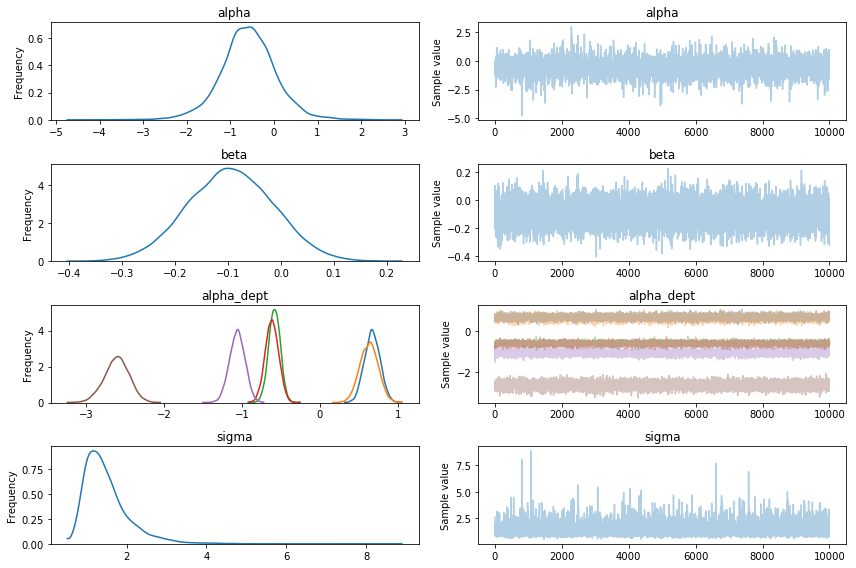

In [153]:
pm.traceplot(m106_traces);

In [154]:
m106_traces_df = pm.trace_to_dataframe(m106_traces)

In [157]:
m106_traces_df.mean()

alpha           -0.589402
beta            -0.094677
alpha_dept__0    0.673929
alpha_dept__1    0.628237
alpha_dept__2   -0.583496
alpha_dept__3   -0.616220
alpha_dept__4   -1.059948
alpha_dept__5   -2.608297
sigma            1.487731
dtype: float64

#### 13.2.2 Varying effects of being male

$$A_i \sim Binomial(n_i, p_i) $$

$$logit(p_i) = \alpha_{DEPT[i]} + \beta_{DEPT[i]} * m_i$$

$$
\begin{bmatrix} 
\alpha_{DEPT}\\
\beta_{DEPT}
\end{bmatrix} = MVNormal( \begin{bmatrix} \alpha \\ \beta \end{bmatrix}, \textbf{S})
$$

$$
S = \begin{pmatrix} \sigma_\alpha & 0 \\ 0 & \sigma_\beta\end{pmatrix} 
  * \textbf{R}
  * \begin{pmatrix} \sigma_\alpha & 0 \\ 0 & \sigma_\beta\end{pmatrix} 
$$

$$\alpha \sim Normal(0, 10)$$

$$\beta \sim Normal(0, 1)$$

$$(\sigma_\alpha, \sigma_\beta) \sim HalfCauchy(0, 2)$$

$$ \textbf{R} \sim LKJcorr(2)$$

In [176]:
with pm.Model() as m107:
    
    #alpha = pm.Normal('alpha', mu=0, sd=5, shape=len(d))
    
    alpha = pm.Normal('alpha', 0, 10)
    beta = pm.Normal('beta', 0, 1)
    
    sigma_alpha = pm.HalfCauchy('sigma_alpha', 2)
    sigma_beta  = pm.HalfCauchy('sigma_beta', 2)
    
    Rho   = pm.LKJCorr('corr', n=2, eta=2) 
    Sigma = np.array([
        [sigma_alpha ** 2, sigma_alpha * sigma_beta * Rho], 
        [sigma_alpha * sigma_beta * Rho, sigma_beta ** 2 ]
    ])
        
#     mv_mu = pm.MvNormal('mu', (alpha, beta), Sigma, shape=df.dept_id.nunique())
#     print(mv_mu)
        
#     lin = alpha_dept[df['dept_id'].values] + alpha_dept[df['dept_id'].values] * df['is_male']
#     p = np.exp(lin) / (1 + np.exp(lin))
    
#     admit = pm.Binomial('admit', n=df['applications'].values, p=p, observed=df['admit'])
        
#     m107_map = pm.find_MAP()
#     m107_traces = pm.sample(10000, start=m107_map)

In [192]:
alpha?

In [177]:
Sigma

array([[Elemwise{pow,no_inplace}.0, Elemwise{mul,no_inplace}.0],
       [Elemwise{mul,no_inplace}.0, Elemwise{pow,no_inplace}.0]], dtype=object)